In [1]:
# general import
import numpy as np
import matplotlib.pyplot as plt

# import torch
import torch
torch.set_default_dtype(torch.float32)

# Pytorch main ingredient: tensors

Tensors are glorified numpy arrays: we go from

In [2]:
X_numpy = np.array([0., 1., 2., 3., 4.])

to

In [3]:
X_torch = torch.tensor([0., 1., 2., 3., 4.])

also, you can go back and forth

In [4]:
X_numpy_from_torch = X_torch.numpy()
X_numpy_from_torch

array([0., 1., 2., 3., 4.], dtype=float32)

many functionalities carry over ...

In [5]:
print("min:", X_torch.min().item())
print("max:", X_torch.max().item())

min: 0.0
max: 4.0


NOTE: I'm using item() since the result of a function on a tensor is also a tensor, indeed ...

In [6]:
print(X_torch.max())

tensor(4.)


This is useful when you store records during training of an ML model with backprop

# Where magic happens: backward

Tensor can carry the information about a gradient of any function computed on them: all you have to do is
set their requires_grad variable before computing it

In [7]:
X_torch.requires_grad = True # or equivalently run: X_torch.requires_grad_()

Let's compute a simple (scalar) function of X

In [8]:
f = (X_torch**2).sum()
f

tensor(30., grad_fn=<SumBackward0>)

The result has an associated grad_fn that can be used to compute the gradient wrt to its input variables.

In this case: $\frac{d f}{d x_i} = 2 x_i$ so we expect the gradient to be:

In [9]:
expected_grad = 2. * X_torch.detach()

# WARNING: make sure to use detach() to perform a computation while not tracked by automatic differentiation
# an equivalent approch would be:
# while torch.no_grad():
#     expected_grad = 2. * X_torch

print("the old way of computing a gradient:", expected_grad)

the old way of computing a gradient: tensor([0., 2., 4., 6., 8.])


Pytoch can do it for us for free:

In [10]:
f.backward() # backpropagate and fill the grad variables in the tensor objects

Let's inspect the grad variable in X_torch

In [11]:
print("the pytorch way of computing a gradient:", X_torch.grad)

the pytorch way of computing a gradient: tensor([0., 2., 4., 6., 8.])


In practice we will never actually access grad variables directly but use specific optimizers that can do the job for us.

# The simplest task: linear regression

To learn how all this works, let's solve the simplest of problems

In [12]:
M = 100 # number of input patterns
N = 10 # number of parameters

X = torch.randn(M, N) # input data
y = torch.randn(M) # target data

w = torch.randn(N).requires_grad_() # regression weights

Let's us use gradient descent to solve this problem

In [13]:
lr = 1e-1 # learning rate
num_epochs = 100 # max number of gradient steps

losses = []
for ep in range(1, num_epochs+1):
    y_pred = X @ w # compute predicted output
    loss = ((y_pred - y)**2).mean() # compute loss
    losses += [loss.item()] # record loss
    
    # zero grad
    if w.grad is not None:
        w.grad.zero_()
    
    # compute gradient
    loss.backward()
    
    # apply gradient descent step
    w.data -= lr * w.grad

Check the loss dynamics through learning

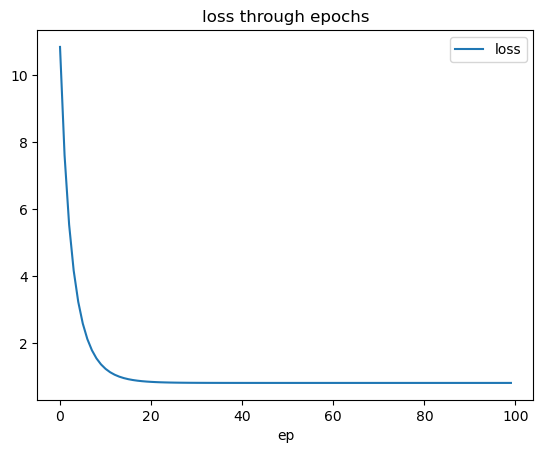

In [14]:
plt.plot(losses, label="loss");
plt.title("loss through epochs");
plt.xlabel("ep");
plt.legend();

Did we actually find the optimal w?

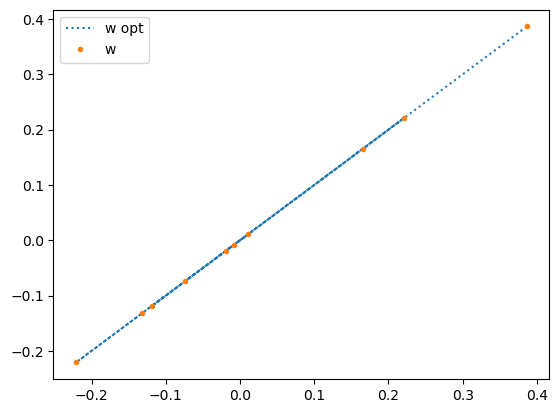

In [16]:
# compute optimal w from pseudo-inverse
w_opt = torch.linalg.inv(X.T @ X) @ (X.T @ y)

# compare with solution found by gradient descent
plt.plot(w_opt.numpy(), w_opt.numpy(), ':', label="w opt");
plt.plot(w_opt.numpy(), w.detach().numpy(), '.', label="w");
plt.legend();

# A network with one hidden layer: let's make sure torch works as it should

We'll check what pytorch can do on a simple network with one hidden layer trained on random input-output pairs

In [25]:
N = 50 # input dimension
M = 100 # number of input patterns

X = torch.randn(M, N)

We'll use random {-1,+1} labels for simplicity:

In [28]:
y = 2. * torch.randint(2, size=(M,)) - 1

have a look at the labels:

In [29]:
y

tensor([ 1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,
        -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,
         1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
        -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,
        -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
        -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,
        -1., -1.])

Initialize both layers

In [30]:
K = 11 # number of neurons in the hidden layer

W = torch.randn(N, K).requires_grad_() # first layer weights
w = torch.randn(K).requires_grad_() # second layer (readout) weights

For simplicity, we'll use a network with a linear output. Let's apply the layer to out inputs:

$y_{pred}^\mu = \sum_{ = 1}^{K} w_k\phi \left(h^\mu_k\right)$

where:

$h^\mu_k = \sum_{i = 1}^{N} W_{ki} x_i^\mu$

and we called $\phi$ the nonlinearity (in this case $\tanh$).

Make sure to note how I set the dimensions of the W tensor and why it's a transpose w.r.t. the previous formula.

In [31]:
h = X @ W # compute preactivation
phi_h = torch.tanh(h) # pass preactivation through nonlinearity
y_pred = phi_h @ w # compute output

Now, writing the loss as:

$\mathcal{L} = \frac{1}{2 M} \sum_{\mu} \left(y^\mu - \sum_k w_k \tanh \left(\sum_i W_{ki} x_i^\mu\right) \right)^2 $

the true gradients are:

$\frac{ d \mathcal{L}}{d W_{ki}} = \frac{1}{M} \sum_{\mu} \left(y_{pred}^\mu - y^\mu\right) \phi' \left( h_k^\mu \right) w_k x_i^\mu$

$\frac{ d \mathcal{L}}{d w_{k}} = \frac{1}{M} \sum_{\mu} \left(y_{pred}^\mu - y^\mu\right) \tanh \left(h_k^\mu\right)$

We compute the gradients:

In [32]:
delta = y_pred - y
loss = 0.5 * (delta**2).mean()

with torch.no_grad():
    dphi_h = 1. - phi_h**2 # derivative of tanh as a function of its output
    grad_W_expected = (X.T @ (torch.outer(delta, w) * dphi_h)) / len(X) # gradient w.r.t W
    grad_w_expected = (delta[:,None] * phi_h).mean(0) # gradient w.r.t 2

Let's check that pytorch computes the exact gradients

In [33]:
loss.backward()

grad_W_torch = W.grad
grad_w_torch = w.grad

In [34]:
yes_or_not_w = "" if torch.allclose(grad_w_torch, grad_w_expected) else " not"
print(f"grad w is{yes_or_not_w} OK")

yes_or_not_W = "" if torch.allclose(grad_W_torch, grad_W_expected) else " not"
print(f"grad w is{yes_or_not_W} OK")

grad w is OK
grad w is OK


And lastly we make a final visual check

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(grad_w_expected.numpy().flatten(), grad_w_expected.numpy().flatten(), ':', label="expected");
plt.plot(grad_w_expected.numpy().flatten(), grad_w_torch.numpy().flatten(), '.', label="torch");
plt.legend();
plt.title("w");
plt.xlabel("W");

plt.subplot(122)
plt.plot(grad_W_expected.numpy().flatten(), grad_W_expected.numpy().flatten(), ':', label="expected");
plt.plot(grad_W_expected.numpy().flatten(), grad_W_torch.numpy().flatten(), '.', label="torch");
plt.legend();
plt.title("W");
plt.xlabel("w");

plt.tight_layout();

## Let's train the network

Compute output of untrained network first

In [ ]:
h = X @ W
phi_h = torch.tanh(h)
y_pred_init = phi_h @ w

plt.hist(y_pred.detach()[y==-1], histtype="step", label="y = -1");
plt.hist(y_pred.detach()[y==+1], histtype="step", label="y = +1");
plt.legend();

Now let's train this simple network using gradient descent

In [37]:
lr = 1e-1 # learning rate
num_epochs = 5000 # max number of gradient steps

losses = []
for ep in range(1, num_epochs+1):
    
    # compute network output
    h = X @ W
    phi_h = torch.tanh(h)
    y_pred = phi_h @ w
    
    # compute loss
    delta = y_pred - y
    loss = 0.5 * (delta**2).mean()
    losses += [loss.item()]
    
    # zero grad
    if W.grad is not None:
        W.grad.zero_()
    if w.grad is not None:
        w.grad.zero_()
        
    # compute gradient
    loss.backward()
    
    # apply gradient descent step
    W.data -= lr * W.grad
    w.data -= lr * w.grad

In [ ]:
plt.plot(losses, label="loss");
plt.title("loss through epochs");
plt.xlabel("ep");
plt.legend();

Let's check what our network is doing

In [ ]:
plt.hist(y_pred.detach()[y==-1], histtype="step", label="y = -1");
plt.hist(y_pred.detach()[y==+1], histtype="step", label="y = +1");
plt.legend();

# Where do we go from here

1. It is best to wrap the network in a class;


2. It is costumary to use pytorch dataloaders for inputs and targets. This is especially good for speed when you have acces to a GPU;


3. Torch optimizer greatly simplify gradient updates.